# Measure the radial velocity
This notebook uses the RVFitter class to do an MCMC fit. It looks up the spectral type on Simbad to estimate the temperature, and estimates the log(g) from the spectrum (you should have a Balmer line in there somewhere).

In [1]:
# Import a bunch of stuff
import StarData
import HelperFunctions
import Fitters
import Mamajek_Table
import SpectralTypeRelations
import matplotlib.pyplot as plt
import logging
import triangle
from astropy.io import fits
import numpy as np
import sys
import os

#%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Get the HDF5 filename. Might want to change this eventually.
home = os.environ['HOME']
hdf5_filename = '/media/ExtraSpace/Kurucz_FullGrid/CHIRON_grid_air.hdf5'

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.


/Users/kgulliks/anaconda/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [ ]:
# This function looks up the spectral type from simbad and uses the table from 
#  Pecaut & Mamajek to convert that into an effective temperature.

MT = Mamajek_Table.MamajekTable()
MS = SpectralTypeRelations.MainSequence()
sptnum2teff = MT.get_interpolator('SpTNum', 'Teff') 

def make_fitter(fname, Teff=None, logg=4.0, feh=0.0, first_order=3, last_order=19):
    orders = HelperFunctions.ReadExtensionFits(fname)
    
    if Teff is None:
        header = fits.getheader(fname)
        starname = header['OBJECT']
        SpT = StarData.GetData(starname).spectype
        Teff = sptnum2teff(MS.SpT_To_Number(SpT))

    # make sure Teff is in the grid
    hdf5_int = Fitters.StellarModel.HDF5Interface(hdf5_filename)
    grid_teffs = np.unique([d['temp'] for d in hdf5_int.list_grid_points])
    if Teff > max(grid_teffs):
        Teff = max(grid_teffs)
    #idx = np.argmin((grid_teffs - Teff)**2)
    #Teff = grid_teffs[idx]
    print(Teff)


    print(hdf5_filename)
    fitter = Fitters.RVFitter(orders[first_order:last_order+1], model_library=hdf5_filename, 
                              T=Teff, logg=logg, feh=feh, norm_model=False)
    return fitter

In [ ]:
# Use the fitter to flatten the spectrum
#fitter = make_fitter('Adam_Data/20140210/HIP_56561.fits', logg=4.0, first_order=3, last_order=19)
reload(Fitters)
fitter = make_fitter('../20150113/HIP_24505.fits', logg=4.0, first_order=3, last_order=19)
pars = fitter.guess_fit_parameters(vsini_trials=20, refine=True, N=10)

In [ ]:
print(pars)
print(fitter._T, fitter._logg)
%matplotlib notebook
flattened_orders = fitter.flatten_spectrum(plot=True, pars=pars)

In [37]:
def remake_fitter(filename, model_library, teff, logg, feh=0.0, output_basename='../RVFitter_flattened'):
    print(filename, teff, logg)
    # Read in the (assumed flattened) spectra
    all_orders = HelperFunctions.ReadExtensionFits(filename)
    orders = [o.copy() for o in all_orders if o.x[0] < 475 or o.x[-1] > 495]
    
    #orders = all_orders
    # Set up the fitter
    fitter = Fitters.RVFitter(orders, model_library=model_library,
                              T=teff, logg=logg, feh=feh)
    header = fits.getheader(filename)
    starname = header['OBJECT']
    date = header['DATE-OBS'].split('T')[0]
    stardata_str = '{}_{}-'.format(starname.replace(' ', ''), date.replace('-', ''))
    basename = os.path.join(output_basename, stardata_str)

    # Fit
    fitter.fit(backend='multinest', n_live_points=1000, basename=basename, overwrite=False, init_MPI=False)
    
    return fitter


In [3]:
import pandas as pd
df = pd.read_csv('../Flatten.log', header=None, names=['fname', 'star', 'date', 'teff', 'logg', 'rv_guess'])
df.head()

,fname,star,date,teff,logg,rv_guess
0,20140514/HIP_85537.fits,HIP 85537,2014-05-15,7364.229691,3.330221,46.462539
1,20140804/HIP_79007.fits,HIP 79007,2014-08-04,7691.750679,3.766727,-26.690580
2,20140804/HIP_2381.fits,HIP 2381,2014-08-05,8448.354758,3.393724,8.241084
3,20130206/HIP_41039.fits,HIP 41039,2013-02-07,26000.000000,4.000000,100.000000
4,20150321/HIP_85922.fits,HIP 85922,2015-03-22,7866.455266,4.476049,45.578677


In [13]:
df.loc[df.star == 'HIP 29735']

,fname,star,date,teff,logg,rv_guess
118,20130923/HIP_29735.fits,HIP 29735,2013-09-24,10700,4,7.150323


In [38]:
idx = 155
print df.loc[idx, 'fname']
fname = '../{}'.format(df.loc[idx, 'fname'].replace('.fits', '_renormalized.fits'))
#fname = '../20130201/HIP_5348_renormalized2.fits'
teff = df.loc[idx, 'teff']
logg = df.loc[idx, 'logg']
hdf5_filename = '/Volumes/DATADRIVE/Kurucz_Grid/CHIRON_grid_air.hdf5'
reload(Fitters)
fitter = remake_fitter(fname, hdf5_filename, teff, logg, output_basename='../RVFitter_flattened/')

20130711/HIP_105140.fits
('../20130711/HIP_105140_renormalized.fits', 9199.4041754699992, 3.6206912007199996)
Determine Chunk Log: Wl is 131072


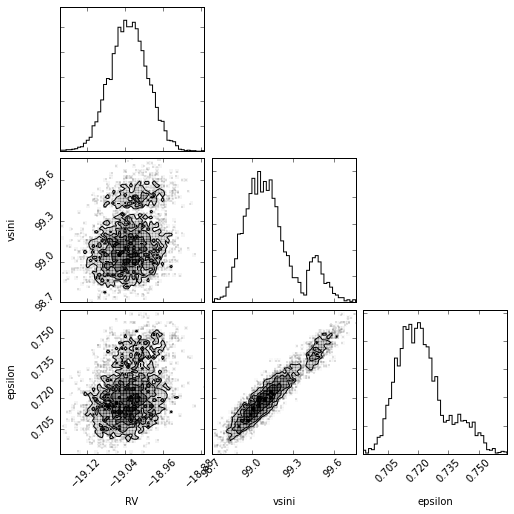

In [18]:
%matplotlib inline
fitter.triangle()

<IPython.core.display.Javascript object>


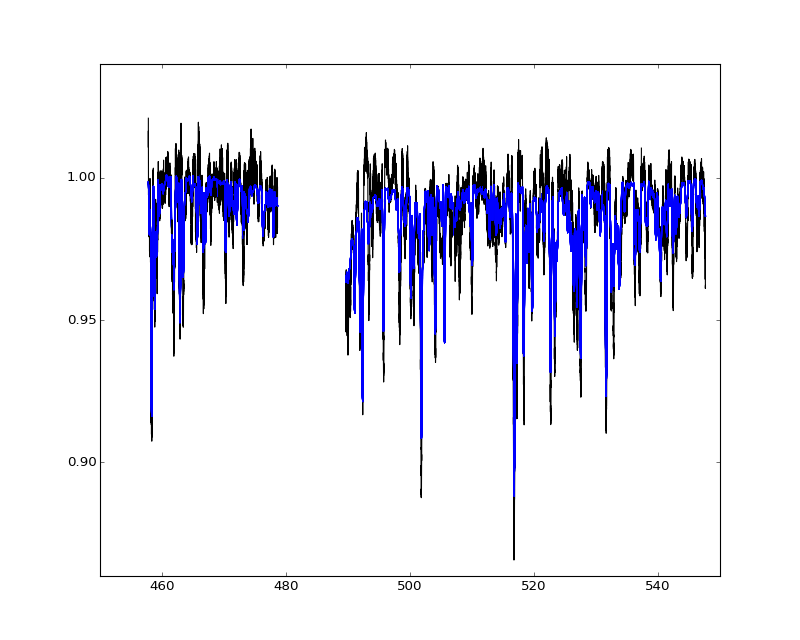

In [41]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(10,8))
fitter.samples.RV -= 0.53
fitter.plot(ax=ax, N=30)
#plt.ylim((-0.1, 1.5))

19.5574758331


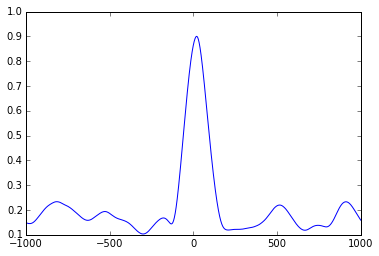

In [39]:
import Correlate
import DataStructures

orders = [DataStructures.xypoint(x=x, y=y) for x, y in zip(fitter.x, fitter.y)]
ccf = Correlate.GetCCF(orders, fitter.model_spec, vsini=100, resolution=80000, addmode='ml')
corr = ccf['CCF']

%matplotlib inline
plt.plot(corr.x, corr.y)
print(corr.x[np.argmax(corr.y)])

In [40]:
fitter.samples.describe()

,RV,epsilon,lnprob,vsini
count,4373.000000,4373.000000,4373.000000,4373.000000
mean,-19.030972,0.721981,-129334.383813,99.133215
std,0.039926,0.012206,1.214255,0.187875
min,-19.191501,0.692044,-129341.905365,98.733604
25%,-19.057650,0.713192,-129334.989031,98.999642
50%,-19.030987,0.720147,-129334.137599,99.101527
75%,-19.003759,0.728254,-129333.452584,99.221212
max,-18.905849,0.765483,-129332.765274,99.824551


In [35]:
19.03 - 18.48

0.5500000000000007